# Plasmonic photothermal heating of gold nanoparticles

Note: the cost of running the entire notebook is larger than 5 FlexCredit.

Metallic nanoparticles, particularly those made of gold (Au), have the unique ability to strongly interact with light at specific wavelengths through a phenomenon known as Localized Surface Plasmon Resonance (LSPR). When illuminated at their resonance frequency, these nanoparticles become highly efficient at absorbing light and converting it into heat on the nanoscale. This localized heat generation is the foundation of Plasmonic Photothermal Therapy (PPTT), a technique for applications like selective oncological treatment. By delivering nanoparticles to a target volume (e.g., a tumor) and illuminating them with light (often in the near-infrared, where biological tissue is most transparent), it's possible to induce hyperthermia with high precision, minimizing damage to surrounding healthy tissue. Computational modeling tools, such as Tidy3D, offers a powerful tool for predicting the temperature increase for different nanoparticle shapes, sizes, and arrangements, allowing scientists to rapidly simulate and predict thermal outcomes.

This notebook reproduces the simulation results of the paper `Multiphysics Modeling of Plasmonic Photothermal Heating Effects in Gold Nanoparticles and Nanoparticle Arrays` https://doi.org/10.1021/acs.jpcc.0c02443 . We will use Tidy3D's electromagnetic and Heat solver to model the temperature increase of a single golden nanosphere (GNS) and a single golden nanorod (GNR)

<img src="img/plasmonic_phothotermal_heating.png" width="400" alt="Golden Nanosphere representation">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import xarray as xr

We define the shared parameters for all subsequent simulations, including the material optical and thermal properties, and some characteristics of the optical source.

In [2]:
# location of the nanoparticle
center = [0, 0, 0]

# nanoparticle material
gold_medium_opt = td.material_library["Au"]["JohnsonChristy1972"]
water_medium_opt = td.material_library["H2O"]["Horiba"]

# heat properties
k_gold_SI = 310  # W/(m*K)
cp_gold_SI = 129  # J/(kg*K)

k_water_SI = 0.6  # W/(m*K)
cp_water_SI = 4184  # J/(kg*K)


water_medium = td.MultiPhysicsMedium(
    name="water",
    optical=water_medium_opt,
    heat=td.SolidSpec(
        conductivity=k_water_SI * 1e-6,  # W/(um*K)
        capacity=cp_water_SI,
    ),
)

gold_medium = td.MultiPhysicsMedium(
    name="gold",
    optical=gold_medium_opt,
    heat=td.SolidSpec(conductivity=k_gold_SI * 1e-6, capacity=cp_gold_SI),
)
# background for heat simulation
background_medium = td.MultiPhysicsMedium(name="background", heat=td.FluidMedium())

# free space central wavelength of the pulse excitation
wavelength = 808e-3  # µm
f0 = td.C_0 / wavelength  # Hz

# bandwidth in Hz
fwidth = f0 / 100
fmin = f0 - fwidth
fmax = f0 + fwidth
wavelength_max = td.C_0 / fmin
wavelength_min = td.C_0 / fmax

# Simulation run time
run_time = 5 / fwidth

## Building the Geometries
Similarly to the article's simulation settings, we consider a Golden Nanosphere (GNP) with a radius of 68 nm and Golden Nanorod with a radius of 26, 91nm height and 11nm of the radius tip. The surrounding medium is water. A Perfectly matched layer (PML) is imposed at the simulation boundaries.

In [3]:
radius = 68e-3 / 2

# create the sphere
sphere_geom = td.Sphere(center=center, radius=radius)
sphere = td.Structure(geometry=sphere_geom, medium=gold_medium.optical)
geometry = [sphere]

In [4]:
## Golden nanorods
radius_gnr = 26e-3 / 2
radius_tip = 11e-3
height_gnr = 91e-3

# building nanorods. One cylinder, two ellipse made out of spheres, merged with union.
cyl = td.Cylinder(center=(0, 0, 0), radius=radius_gnr, length=height_gnr - 2 * radius_tip, axis=1)
sphere_l = td.Sphere(center=(0, -height_gnr / 2 + radius_tip, 0), radius=radius_tip).scaled(
    radius_gnr / radius_tip, 1, radius_gnr / radius_tip
)
sphere_r = td.Sphere(center=(0, height_gnr / 2 - radius_tip, 0), radius=radius_tip).scaled(
    radius_gnr / radius_tip, 1, radius_gnr / radius_tip
)
rod = cyl + sphere_l + sphere_r
geometry_rod = td.Structure(geometry=rod, medium=gold_medium.optical)

In [5]:
# distance between the surface of the geometry and the start of the PML layers along each cartesian direction
buffer_pml = wavelength_max / 2

# set the full simulation size along x, y, and z
sim_size = (2 * wavelength,) * 3

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

## Specify the Source


We'll use a TFSF source surrounding the nanoparticles. This source in Tidy3D is normalized with an intensity of 1 W/µm², differently from the article where authors employ a source normalized with 1 mW/µm². Therefore, a $\sqrt{10^{-3}}$ scaling on the electric field ($10^{-3}$ on the power) is applied to match the article's source normalization.

In [6]:
# distance between particle and the boundary of the tfsf box
buffer_tfsf = 0.3 * radius
tfsf_size = (radius + buffer_tfsf) * 2

In [7]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, amplitude=np.sqrt(1e-3))

# the tfsf source is defined as a box around the particle
source = td.TFSF(
    center=center,
    size=(tfsf_size,) * 3,
    source_time=gaussian,
    injection_axis=2,  # inject along the z axis...
    direction="+",
    name="tfsf",
    pol_angle=np.pi / 2,
)

In [8]:
tfsf_size_rod = (radius_gnr * 1.3 * 2, height_gnr * 1.5, radius_gnr * 1.3 * 2)
source_rod = td.TFSF(
    center=center,
    size=tfsf_size_rod,
    source_time=gaussian,
    injection_axis=2,  # 2,  # inject along the z axis...
    direction="+",
    name="tfsf",
    pol_angle=np.pi / 2,
)

## Build Monitors for Electric Field and Permittivity


To calculate the power absorbed by the nanoparticle, we add electric field and a permittivity monitors. These monitors  automatically captures the electric field and material permittivity data needed to compute the local heat source in a subsequent part of the notebook. In the field monitor, `colocate` is set to `False` so that the field data matches with the grid specification of the permittivity monitor (where `colocate` is set to `False` by default).

In [9]:
num_freqs = 3
freqs = np.linspace(f0 - fwidth, f0 + fwidth, num_freqs)
monitor_size = (radius * 6,) * 3

# Permittivity monitor
monitor_perm = td.PermittivityMonitor(
    center=center,
    size=monitor_size,
    freqs=freqs,
    name="permittivity",
)

# Field monitor
monitor_E_field = td.FieldMonitor(
    center=center,
    size=monitor_size,
    freqs=freqs,
    fields=["Ex", "Ey", "Ez"],
    colocate=False,
    name="dft_fields_monitor",
)

# List of monitors
monitors = [
    monitor_perm,
    monitor_E_field,
]

## Create Simulation


We specify an non-uniform meshing strategy to get denser mesher around the nanoparticles. Then, we assemble the complete electromagnetic `td.Simulation` object for both the GNP and the GNR.

In [10]:
cells_per_wavelength = 20
cells_in_particle_sphere = 40

# An override region with increased mesh density is defined around the object, employing a buffer for smooth transitions to the coarser mesh.
buffer_override = 0.5 * radius
override_size_sphere = (radius + buffer_override) * 2
mesh_override_sphere = td.MeshOverrideStructure(
    geometry=td.Box(center=center, size=(override_size_sphere,) * 3),
    dl=(2 * radius / cells_in_particle_sphere,) * 3,
)

grid_spec_sphere = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[mesh_override_sphere],
    max_scale=1.3,
)

In [11]:
sim_sphere = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec_sphere,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    shutoff=1e-8,
    medium=water_medium.optical,
)

In [12]:
cells_in_particle_nanorods = 40
override_size_rod = (radius_gnr * 1.5 * 2, height_gnr * 2.0, radius_gnr * 1.5 * 2)
mesh_override_rod = td.MeshOverrideStructure(
    geometry=td.Box(center=center, size=override_size_rod),
    dl=(2 * radius_gnr / cells_in_particle_nanorods,) * 3,
)

grid_spec_rod = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[mesh_override_rod],
    max_scale=1.3,
)

In [13]:
sim_rod = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec_rod,
    structures=[geometry_rod],
    sources=[source_rod],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    shutoff=1e-8,
    medium=water_medium.optical,
)

## Visualize Simulation Information

Before submitting our simulation to the server, it is a crucial best practice to visualize the setup. This allows us to confirm that all components—including the geometry, material properties, sources, monitors, and boundary conditions—are positioned and defined as intended. Tidy3D's built-in plotting methods provide a quick and easy way to inspect the simulation layout in 2D or 3D. Given the simplicity of the geometries employed in this example, we only show 2D plots. To employ 3D plots within the notebook, see [`plot_3D`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation.plot_3d) . For Tidy3D advanced visualization capabilites see the [GUI tutorial](https://www.flexcompute.com/tidy3d/learning-center/tidy3d-gui/).

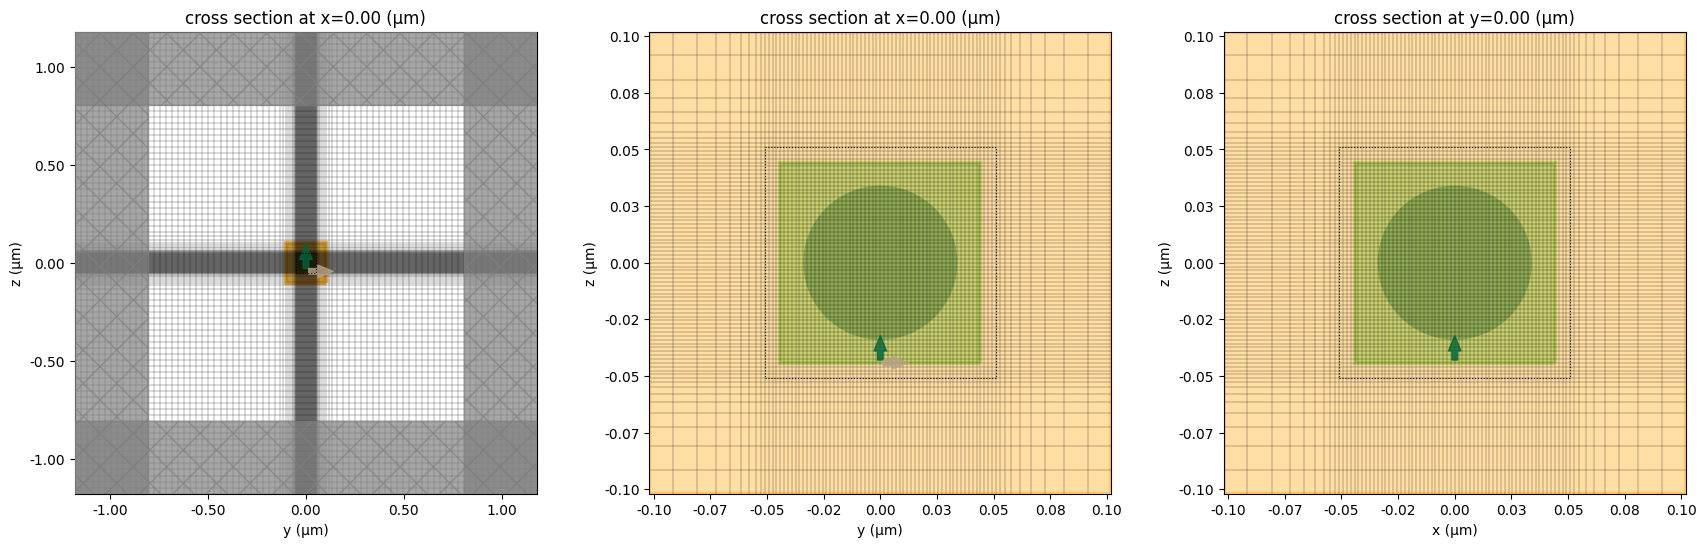

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
zoom = radius * 3.0
sim_sphere.plot(x=0, ax=ax1)
sim_sphere.plot_grid(x=0, ax=ax1)
sim_sphere.plot(x=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom], monitor_alpha=0.2)
sim_sphere.plot_grid(x=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom])
sim_sphere.plot(y=0, ax=ax3, hlim=[-zoom, zoom], vlim=[-zoom, zoom], monitor_alpha=0.2)
sim_sphere.plot_grid(y=0, ax=ax3, hlim=[-zoom, zoom], vlim=[-zoom, zoom])
plt.show()

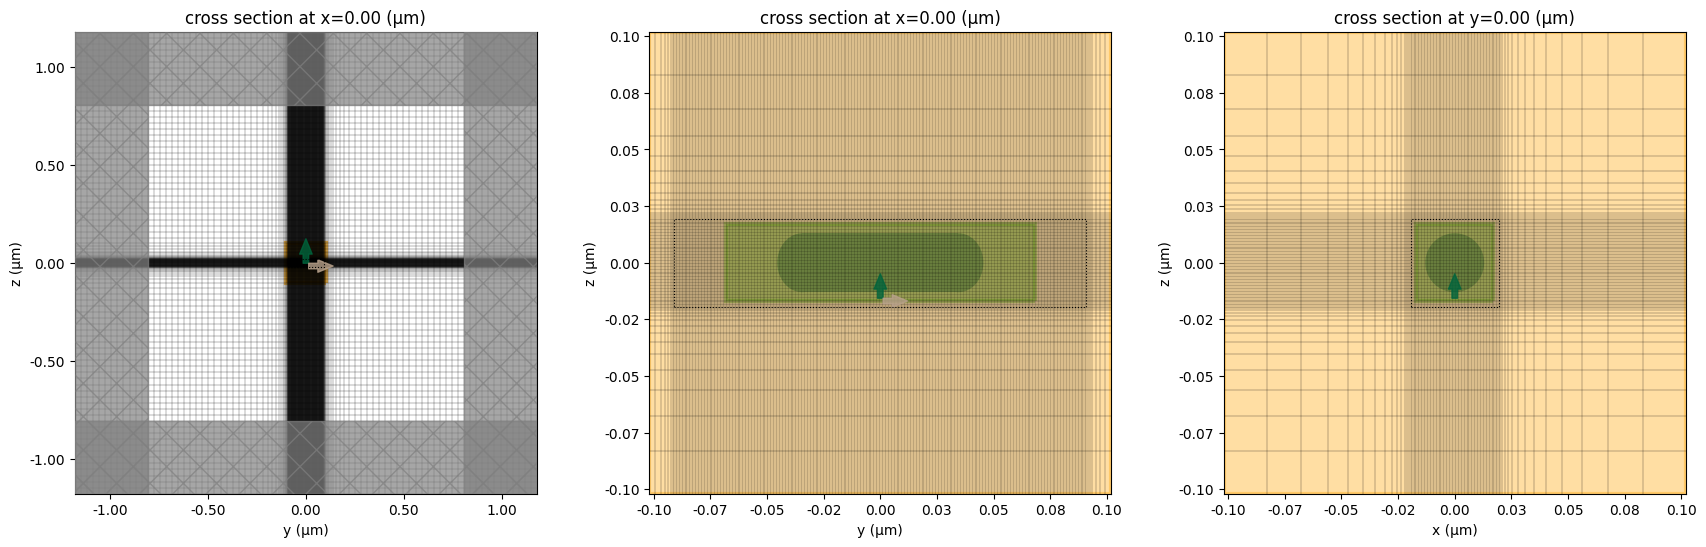

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))
zoom = radius * 3.0
sim_rod.plot(x=0, ax=ax1)
sim_rod.plot_grid(x=0, ax=ax1)
sim_rod.plot(x=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom], monitor_alpha=0.2)
sim_rod.plot_grid(x=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom])
sim_rod.plot(y=0, ax=ax3, hlim=[-zoom, zoom], vlim=[-zoom, zoom], monitor_alpha=0.2)
sim_rod.plot_grid(y=0, ax=ax3, hlim=[-zoom, zoom], vlim=[-zoom, zoom])
plt.show()

## Run the Simulations

In [16]:
# Run simulation
sim_data_sphere = web.run(
    sim_sphere,
    task_name="photothermal_heating_gold_nanoparticle",
    path="data/phototermal_heating_gold_nanoparticle.hdf5",
    verbose=True,
)

12:47:05 CEST Created task 'photothermal_heating_gold_nanoparticle' with task_id
              'fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=994108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=229087;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\taskId]8;;\]8;id=994108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\=]8;;\]8;id=334697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\fdve]8;;\]8;id=994108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\-db87b8a3-29]8;;\
              ]8;id=994108;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\f9-49fe-a2a7-12fac7074e6b']8;;\.

              Task folder: ]8;id=847930;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

12:47:09 CEST Maximum FlexCredit cost: 0.777. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

12:47:10 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:47:15 CEST status = preprocess

12:47:19 CEST starting up solver

              running solver

Output()

12:48:44 CEST early shutoff detected at 32%, exiting.

              status = postprocess

Output()

12:48:47 CEST status = success

12:48:49 CEST View simulation result at                                         
              ]8;id=262476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=491203;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\taskId]8;;\]8;id=262476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\=]8;;\]8;id=648052;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\fdve]8;;\]8;id=262476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\-db87b8a3-29]8;;\
              ]8;id=262476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-db87b8a3-29f9-49fe-a2a7-12fac7074e6b\f9-49fe-a2a7-12fac7074e6b']8;;\.

Output()

12:49:09 CEST loading simulation from                                           
              data/phototermal_heating_gold_nanoparticle.hdf5

In [17]:
# Run simulation
sim_data_rods = web.run(
    sim_rod,
    task_name="photothermal_heating_gold_nanorods",
    path="data/phototermal_heating_gold_nanorods.hdf5",
    verbose=True,
)

12:49:11 CEST WARNING: Simulation has 1.09e+06 time steps. The 'run_time' may be
              unnecessarily large, unless there are very long-lived resonances. 

              Created task 'photothermal_heating_gold_nanorods' with task_id    
              'fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=732845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=163142;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\taskId]8;;\]8;id=732845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\=]8;;\]8;id=666273;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\fdve]8;;\]8;id=732845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\-4df7bfa7-63]8;;\
              ]8;id=732845;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\db-42a3-b4bc-1c171c2b5bdf']8;;\.

              Task folder: ]8;id=499072;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

12:49:14 CEST Maximum FlexCredit cost: 5.367. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

12:49:15 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:49:20 CEST status = preprocess

12:49:25 CEST starting up solver

              running solver

Output()

12:55:24 CEST early shutoff detected at 32%, exiting.

              status = postprocess

Output()

12:55:31 CEST status = success

12:55:33 CEST View simulation result at                                         
              ]8;id=504135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=912791;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\taskId]8;;\]8;id=504135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\=]8;;\]8;id=569761;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\fdve]8;;\]8;id=504135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\-4df7bfa7-63]8;;\
              ]8;id=504135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4df7bfa7-63db-42a3-b4bc-1c171c2b5bdf\db-42a3-b4bc-1c171c2b5bdf']8;;\.

Output()

12:55:54 CEST loading simulation from                                           
              data/phototermal_heating_gold_nanorods.hdf5

## Extract the results

### Fields and Power GNP (Sphere)

The volumetric power absorption density $p_{abs}(x, y, z) $ in a lossy material exposed to an electric field can be expressed as: $p_\text{abs}(x,y,z) = \pi f \; \epsilon'' |E(x,y,z)|^2 $, where $\epsilon''$ is the immaginary part of the permittivity. For more details on the absorbed power computation, refer to [this](https://www.flexcompute.com/tidy3d/examples/notebooks/PlasmonicNanoparticle/) example.

In [18]:
def computeAbsPowerAndE(simulation_data):
    field_data = simulation_data[monitor_E_field.name]
    field_data_colocated = simulation_data.at_boundaries(monitor_E_field.name).interp(
        f=f0, method="nearest"
    )
    coords = field_data_colocated.Ex.coords
    coords_dict = {dim: coords.get(dim) for dim in "xyz"}

    Ex = field_data.Ex.interp(f=f0, method="nearest")
    Ey = field_data.Ey.interp(f=f0, method="nearest")
    Ez = field_data.Ez.interp(f=f0, method="nearest")

    monitor_data_perm = simulation_data.monitor_data[monitor_perm.name]
    perm_x = monitor_data_perm.eps_xx.interp(f=f0, method="nearest")
    perm_y = monitor_data_perm.eps_yy.interp(f=f0, method="nearest")
    perm_z = monitor_data_perm.eps_zz.interp(f=f0, method="nearest")

    # Calculate the squared magnitude for each E-field component.
    E_squared_magnitude_x = Ex * Ex.conj()
    E_squared_magnitude_y = Ey * Ey.conj()
    E_squared_magnitude_z = Ez * Ez.conj()
    E_magnitude = np.sqrt(
        (Ex * Ex.conj()).interp(**coords_dict)
        + (Ey * Ey.conj()).interp(**coords_dict)
        + (Ez * Ez.conj()).interp(**coords_dict)
    )

    # Compute the power density for each E-field component using the imaginary part of permittivity.
    Power_density_E_x = np.pi * f0 * td.constants.EPSILON_0 * perm_x.imag * E_squared_magnitude_x
    Power_density_E_y = np.pi * f0 * td.constants.EPSILON_0 * perm_y.imag * E_squared_magnitude_y
    Power_density_E_z = np.pi * f0 * td.constants.EPSILON_0 * perm_z.imag * E_squared_magnitude_z
    Power_density_E = (
        Power_density_E_x.interp(**coords_dict)
        + Power_density_E_y.interp(**coords_dict)
        + Power_density_E_z.interp(**coords_dict)
    )
    return (
        coords_dict,
        Power_density_E,
        Power_density_E_x,
        Power_density_E_y,
        Power_density_E_z,
        E_magnitude,
    )

In [19]:
(
    coords_dict_sphere,
    Power_density_E_sphere,
    Power_density_E_x_sphere,
    Power_density_E_y_sphere,
    Power_density_E_z_sphere,
    E_magnitude_sphere,
) = computeAbsPowerAndE(sim_data_sphere)

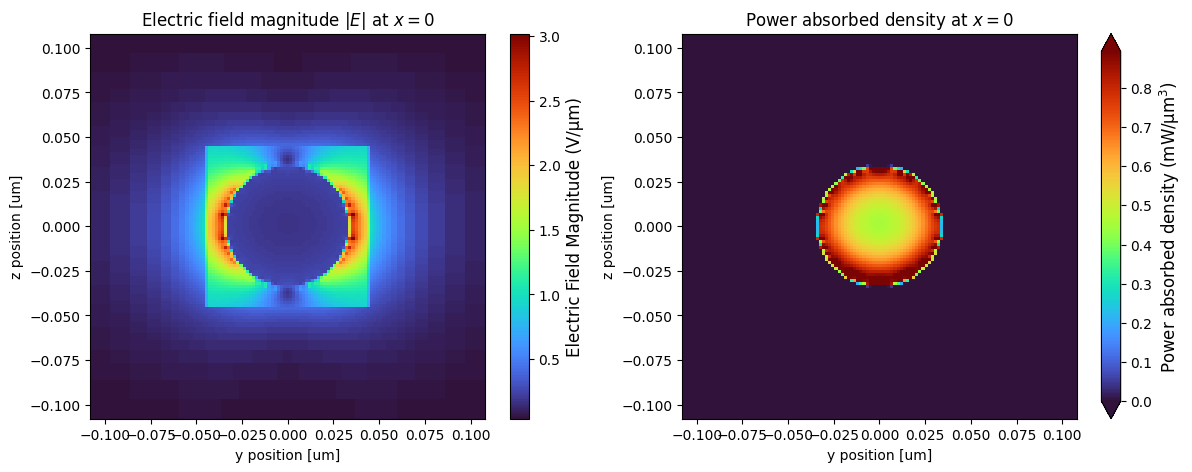

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
scaling = 1  # / Power_density_E.real.max()
fig1 = E_magnitude_sphere.sel(x=0, method="nearest").real.plot(x="y", y="z", cmap="turbo", ax=ax[0])
fig2 = (
    (1e3 * Power_density_E_sphere)
    .sel(x=0, method="nearest")
    .real.plot(x="y", y="z", cmap="turbo", ax=ax[1], robust=True)
)


colorbar_label1 = "Electric Field Magnitude (V/µm)"
fig1.colorbar.set_label(colorbar_label1, fontsize=12)
colorbar_label2 = "Power absorbed density (mW/µm$^3$)"
fig2.colorbar.set_label(colorbar_label2, fontsize=12)

_ = ax[0].set_title("Electric field magnitude $|E|$ at $x=0$")
_ = ax[1].set_title("Power absorbed density at $x=0$")

In [21]:
abs_power_sphere = (
    Power_density_E_x_sphere.integrate(coord=["x", "y", "z"])
    + Power_density_E_y_sphere.integrate(coord=["x", "y", "z"])
    + Power_density_E_z_sphere.integrate(coord=["x", "y", "z"])
)
avg_abs_power_sphere = abs_power_sphere / sphere_geom.volume()
avg_abs_power_sphere_mw = 1e3 * avg_abs_power_sphere.real.values
print(f"Average absorbed power at 0° (angle): {avg_abs_power_sphere_mw:.3f} mW / µm^3")

Average absorbed power at 0° (angle): 0.742 mW / µm^3


### Fields and Power GNR (Nanorods)

In [22]:
(
    coords_dict_rods,
    Power_density_E_rods,
    Power_density_E_x_rods,
    Power_density_E_y_rods,
    Power_density_E_z_rods,
    E_magnitude_rods,
) = computeAbsPowerAndE(sim_data_rods)

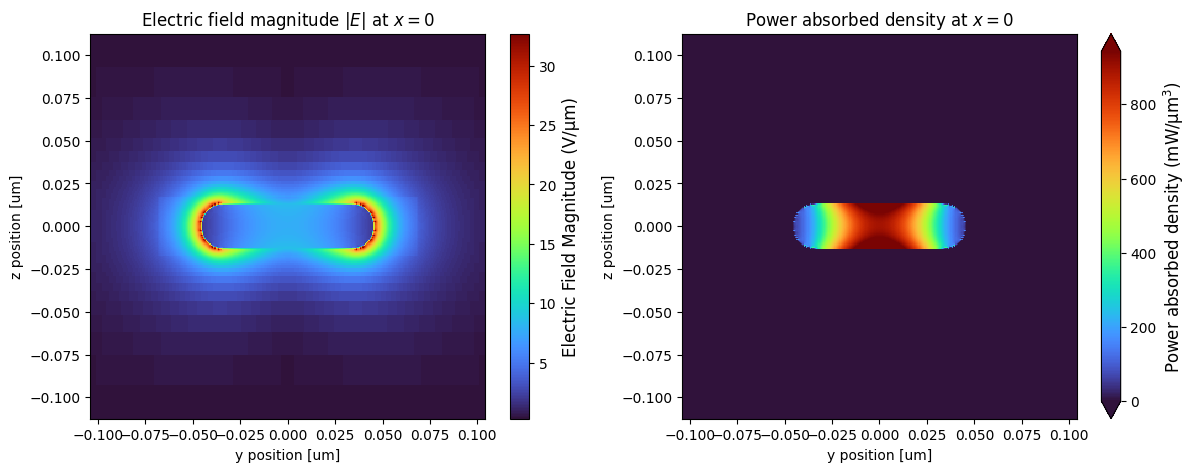

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
scaling = 1  # / Power_density_E.real.max()
fig1 = E_magnitude_rods.sel(x=0, method="nearest").real.plot(x="y", y="z", cmap="turbo", ax=ax[0])
fig2 = (
    (1e3 * Power_density_E_rods)
    .sel(x=0, method="nearest")
    .real.plot(x="y", y="z", cmap="turbo", ax=ax[1], robust=True)
)

colorbar_label1 = "Electric Field Magnitude (V/µm)"
fig1.colorbar.set_label(colorbar_label1, fontsize=12)
colorbar_label2 = "Power absorbed density (mW/µm$^3$)"
fig2.colorbar.set_label(colorbar_label2, fontsize=12)

_ = ax[0].set_title("Electric field magnitude $|E|$ at $x=0$")
_ = ax[1].set_title("Power absorbed density at $x=0$")

In [24]:
abs_power_rod = (
    Power_density_E_x_rods.integrate(coord=["x", "y", "z"])
    + Power_density_E_y_rods.integrate(coord=["x", "y", "z"])
    + Power_density_E_z_rods.integrate(coord=["x", "y", "z"])
)
avg_abs_power_rod = abs_power_rod / rod.volume()
avg_abs_power_rod_mw = 1e3 * avg_abs_power_rod.real.values
print(f"Average absorbed power at 0° (angle): {avg_abs_power_rod_mw:.3f} mW / µm^3")

Average absorbed power at 0° (angle): 525.364 mW / µm^3


## Heat Simulation

For the model's geometry and thermal properties, we will use the objects that were created at the beginning of the notebook. For a steady-state thermal simulation like this one, the key material properties employed in this simulation are the thermal conductivity (k) and the thermal capacity (cp).

For more details on using the heat solver, please refer to this [tutorial](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/HeatSolver.html) in the Tidy3D documentation.

### Create Scenes

Next, we create a `td.Scene` for each scenario (GNS and GNR) by building the corresponding `td.Structure` objects from the geometries and media defined above

In [25]:
# Water sphere surrounding the nanoparticles
water_radius = 20 * radius

sphere_outer = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=water_radius),
    medium=water_medium,
    name="sphere_outer",
)

In [26]:
sphere_inner = td.Structure(
    geometry=td.Sphere(center=(0, 0, 0), radius=radius),
    medium=gold_medium,
    name="sphere_inner",
)

scene_sphere = td.Scene(
    structures=[sphere_outer, sphere_inner],
    medium=background_medium,
)

sim_heat_size = water_radius * 1.2

In [27]:
# Nanorods
rod_inner = td.Structure(
    geometry=rod,
    medium=gold_medium,
    name="rod_inner",
)

scene_rod = td.Scene(
    structures=[sphere_outer, rod_inner],
    medium=background_medium,
)

### Boundary Conditions

Here we set up the boundary conditions for our thermal simulation. Here we assume a constant temperature at the boundary of water and background.

In [28]:
# Convert the temperature in kelvin
temperature1 = 37 + 273.15

bc = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.SimulationBoundary(),
)
bc2 = td.HeatBoundarySpec(
    condition=td.TemperatureBC(temperature=temperature1),
    placement=td.MediumMediumInterface(mediums=["water", "background"]),
)

### Sources

To accurately simulate the temperature increase, we must first define the source of the heat. In this case, heat is generated due to electromagnetic power absorption within the nanoparticles. We will explore two models for defining this heat source, allowing us to compare a simplified approximation with a more physically rigorous approach.

- Uniform heat source : Simpler and idealized. This simpler method assumes that the heat is generated uniformly throughout the entire volume of the structure. This approach uses a single, constant value for the absorbed power density.
- Spatially distributed heat Source : More sophisticated and typically more physically grounded. The absorption of electromagnetic energy is generally not uniform in reality, as it is strongest in regions where the electric field is most intense, and weakest in the regions where the electric field is least intense. To capture this, we use the computed spatially distributed absorption power arising from the previous electromagnetic simulations to calculate the absorbed power density across each point in space.

By defining both sources, we can directly compare the results of the simplified source against the more detailed point-wise source. Simulating both scenarios will allow us to visually evaluate the impact of the heat source on the final temperature profile.

In [29]:
## Spatially distributed heat source (GNS)
source_sphere = np.complex128(avg_abs_power_sphere).real
source_inner_sphere = td.HeatSource(structures=["sphere_inner"], rate=source_sphere)

## Spatially distributed heat source obtained from the simulation
source_sphere_custom_data = td.SpatialDataArray(
    Power_density_E_sphere.real, coords=coords_dict_sphere
)
source_sphere_distributed = td.HeatSource(
    structures=["sphere_inner"], rate=source_sphere_custom_data
)

In [30]:
## Spatially distributed heat source (GNR)
source_rod = np.complex128(avg_abs_power_rod).real
source_inner_rod = td.HeatSource(structures=["rod_inner"], rate=source_rod)

## Spatially distributed heat source obtained from the simulation
source_rods_custom_data = td.SpatialDataArray(Power_density_E_rods.real, coords=coords_dict_rods)
source_rods_distributed = td.HeatSource(structures=["rod_inner"], rate=source_rods_custom_data)

### Create and Run Simulations

In [31]:
# Temperature monitor
temp_mnt = td.TemperatureMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, td.inf), name="temperature"
)

In [32]:
dl_sphere = radius / 5
heat_sim_sphere = td.HeatChargeSimulation.from_scene(
    center=[0, 0, 0],
    size=(sim_heat_size,) * 3,
    scene=scene_sphere,
    boundary_spec=[bc, bc2],
    sources=[
        source_inner_sphere,
    ],
    grid_spec=td.UniformUnstructuredGrid(dl=dl_sphere),
    monitors=[temp_mnt],
    symmetry=(1, 1, 1),
)

In [33]:
heat_sim2_sphere = td.HeatChargeSimulation.from_scene(
    center=[0, 0, 0],
    size=(sim_heat_size,) * 3,
    scene=scene_sphere,
    boundary_spec=[bc, bc2],
    sources=[
        source_sphere_distributed,
    ],
    grid_spec=td.UniformUnstructuredGrid(dl=dl_sphere),
    monitors=[temp_mnt],
)

In [34]:
dl_rod = radius_gnr / 2
heat_sim_rod = td.HeatChargeSimulation.from_scene(
    center=[0, 0, 0],
    size=(sim_heat_size,) * 3,
    scene=scene_rod,
    boundary_spec=[bc, bc2],
    sources=[
        source_inner_rod,
    ],
    grid_spec=td.UniformUnstructuredGrid(dl=dl_rod),
    monitors=[temp_mnt],
    symmetry=(1, 1, 1),
)

In [35]:
heat_sim2_rod = td.HeatChargeSimulation.from_scene(
    center=[0, 0, 0],
    size=(sim_heat_size,) * 3,
    scene=scene_rod,
    boundary_spec=[bc, bc2],
    sources=[
        source_rods_distributed,
    ],
    grid_spec=td.UniformUnstructuredGrid(dl=dl_rod),
    monitors=[temp_mnt],
)

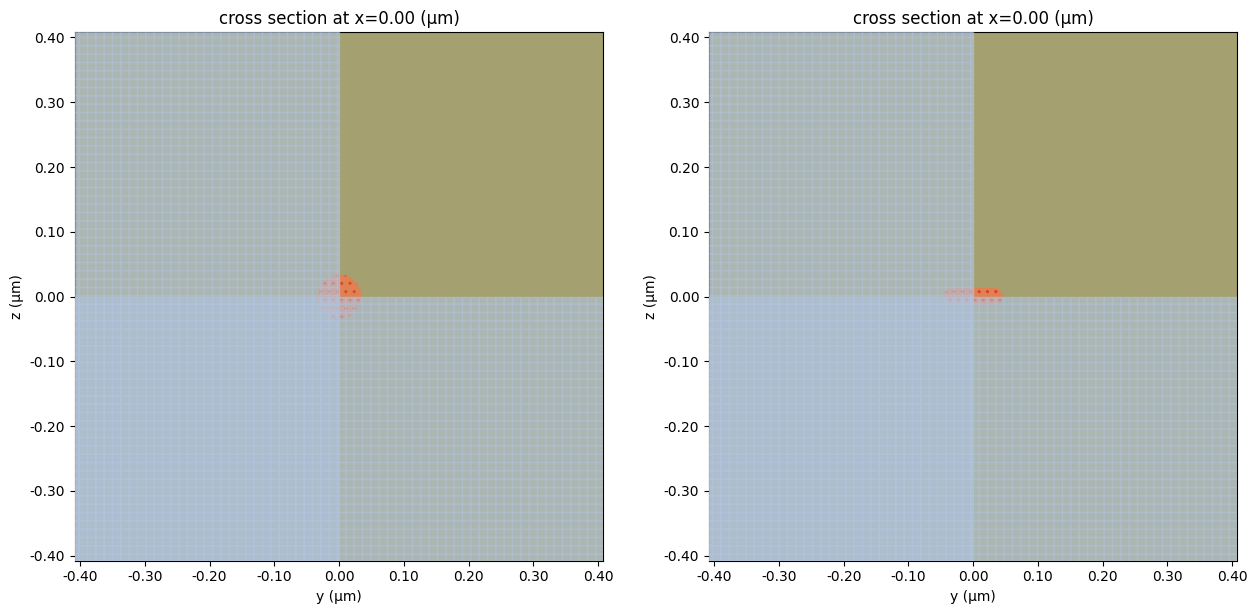

In [36]:
# Optional: Visualize the simulation setup (good for debugging)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig = heat_sim_sphere.plot(x=0, ax=ax[0])
fig = heat_sim_rod.plot(x=0, ax=ax[1])
plt.show()

In [37]:
sim_data_heat_sphere = web.run(
    heat_sim_sphere, task_name="gold_water_heat_sphere", path="data/gold_water_heat.hdf5"
)

12:56:03 CEST Created task 'gold_water_heat_sphere' with task_id                
              'hec-db3d452b-41a7-4271-8b6d-cef23c5c7702' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

12:56:06 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

12:56:07 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:56:48 CEST status = preprocess

12:57:17 CEST starting up solver

12:57:18 CEST running solver

12:57:26 CEST status = success

Output()

12:57:30 CEST loading simulation from data/gold_water_heat.hdf5

In [38]:
sim_data2_heat_sphere = web.run(
    heat_sim2_sphere, task_name="gold_water_heat_sphere2", path="data/gold_water_heat2.hdf5"
)

              Created task 'gold_water_heat_sphere2' with task_id               
              'hec-d9859a2a-d4a3-4f74-8c38-ff73c34f6737' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

12:57:34 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

12:57:35 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

12:57:58 CEST status = preprocess

13:00:01 CEST starting up solver

              running solver

13:00:51 CEST status = success

Output()

13:01:03 CEST loading simulation from data/gold_water_heat2.hdf5

In [39]:
sim_data_heat_rod = web.run(
    heat_sim_rod, task_name="gold_water_heat_rod", path="data/gold_water_heat_rod.hdf5"
)

              Created task 'gold_water_heat_rod' with task_id                   
              'hec-34256064-66b8-416d-b758-4c4a6344321c' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

13:02:26 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:02:28 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:02:58 CEST status = preprocess

13:03:28 CEST starting up solver

              running solver

13:03:35 CEST status = success

Output()

13:03:40 CEST loading simulation from data/gold_water_heat_rod.hdf5

In [40]:
sim_data2_heat_rod = web.run(
    heat_sim2_rod, task_name="gold_water_heat_rod2", path="data/gold_water_heat_rod2.hdf5"
)

13:03:41 CEST Created task 'gold_water_heat_rod2' with task_id                  
              'hec-aa45a669-7c20-4aaf-b6f9-21abc5150925' and task_type          
              'HEAT_CHARGE'.

              Tidy3D's HeatCharge solver is currently in the beta stage. Cost of
              HeatCharge simulations is subject to change in the future.

Output()

13:03:49 CEST Maximum FlexCredit cost: 0.025. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

13:03:50 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

13:04:16 CEST status = preprocess

13:06:53 CEST starting up solver

13:06:54 CEST running solver

13:09:02 CEST status = success

Output()

13:09:13 CEST loading simulation from data/gold_water_heat_rod2.hdf5

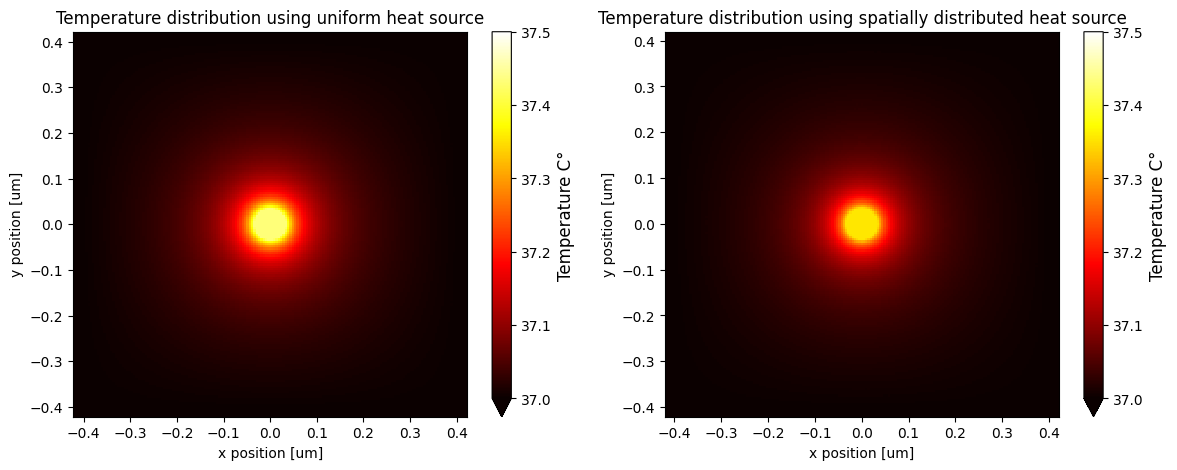

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig1 = (
    (
        (sim_data_heat_sphere.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    )
    .sel(z=0, method="nearest")
    .plot(x="x", y="y", cmap="hot", ax=ax[0], vmin=37, vmax=37.5)
)
fig2 = (
    (
        (sim_data2_heat_sphere.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    )
    .sel(z=0, method="nearest")
    .plot(x="x", y="y", cmap="hot", ax=ax[1], vmin=37, vmax=37.5)
)

colorbar_label = "Temperature C°"
fig1.colorbar.set_label(colorbar_label, fontsize=12)
fig2.colorbar.set_label(colorbar_label, fontsize=12)

_ = ax[0].set_title("Temperature distribution using uniform heat source")
_ = ax[1].set_title("Temperature distribution using spatially distributed heat source")

In [42]:
max_temp_avg_source = np.float64(
    (
        (sim_data_heat_sphere.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    ).max()
)
max_temp_pw_source = np.float64(
    ((sim_data2_heat_sphere.monitor_data["temperature"]).temperature - np.float64(273.15)).max()
)
print("Temperature peak")
print(
    f"Uniform source absorbed power: {max_temp_avg_source:.2f}° - Spatially distributed source absorbed power: {max_temp_pw_source:.2f}°"
)

Temperature peak
Uniform source absorbed power: 37.43° - Spatially distributed source absorbed power: 37.35°


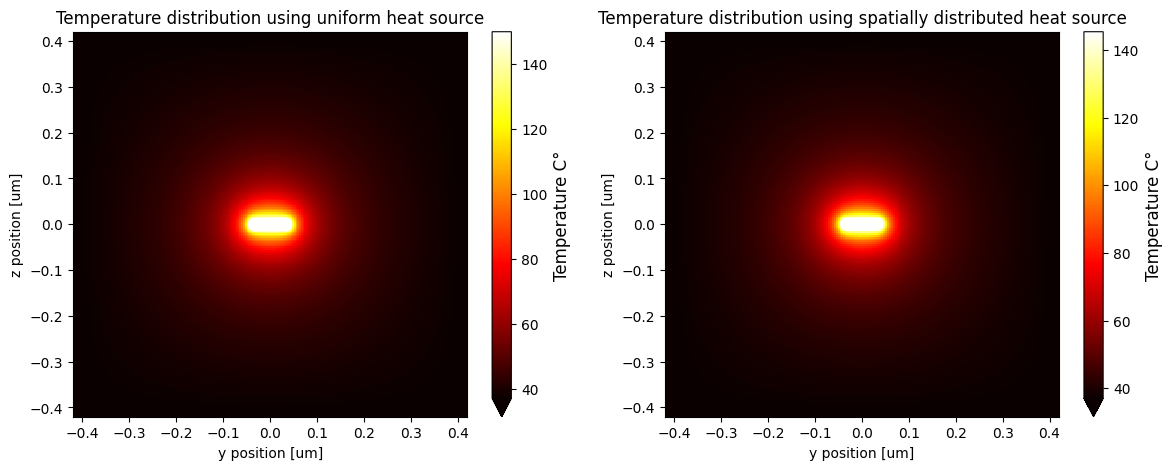

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
fig1 = (
    (
        (sim_data_heat_rod.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    )
    .sel(x=0, method="nearest")
    .plot(x="y", y="z", cmap="hot", ax=ax[0], vmin=37)
)
fig2 = (
    (
        (sim_data2_heat_rod.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    )
    .sel(x=0, method="nearest")
    .plot(x="y", y="z", cmap="hot", ax=ax[1], vmin=37)
)

colorbar_label = "Temperature C°"
fig1.colorbar.set_label(colorbar_label, fontsize=12)
fig2.colorbar.set_label(colorbar_label, fontsize=12)

_ = ax[0].set_title("Temperature distribution using uniform heat source")
_ = ax[1].set_title("Temperature distribution using spatially distributed heat source")

In [44]:
max_temp_avg_source = np.float64(
    (
        (sim_data_heat_rod.monitor_data["temperature"]).symmetry_expanded_copy.temperature
        - np.float64(273.15)
    ).max()
)
max_temp_pw_source = np.float64(
    ((sim_data2_heat_rod.monitor_data["temperature"]).temperature - np.float64(273.15)).max()
)
print("Temperature peak")
print(
    f"Uniform source absorbed power: {max_temp_avg_source:.2f}° - Spatially distributed source absorbed power: {max_temp_pw_source:.2f}°"
)

Temperature peak
Uniform source absorbed power: 149.93° - Spatially distributed source absorbed power: 145.35°


Below, we compare visually the temperature data obtained from the two different source models for the GNS and the GNR. The temperature data is obtained through interpolation around the object of interest. Finally, the absolute differences are calculated and plotted using xarray's built-in plotting capabilities.

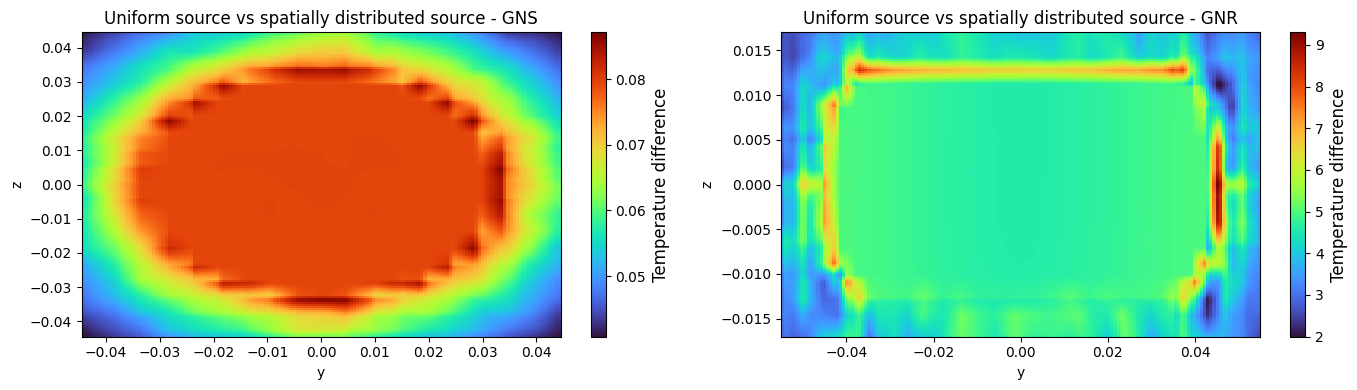

In [45]:
# Create 1D NumPy arrays for the y and z coordinates of the sphere and rod interpolation
# grid. The range and number of points are chosen to cover the relevant regions.
y_sphere = np.linspace(-radius * 1.3, radius * 1.3, 150)
z_sphere = np.linspace(-radius * 1.3, radius * 1.3, 150)
coords_sphere = xr.DataArray(dims=["y", "z"], coords={"y": y_sphere, "z": z_sphere})

y_rod = np.linspace(-height_gnr * 0.6, height_gnr * 0.6, 150)
z_rod = np.linspace(-radius_gnr * 1.3, radius_gnr * 1.3, 150)


# Create an xarray.DataArray to hold these 1D coordinates
# This DataArray itself doesn't contain data values, but defines the structure
# of the target interpolation grid's dimensions and coordinates.
coords_rod = xr.DataArray(dims=["y", "z"], coords={"y": y_rod, "z": z_rod})

# Interpolate temperature data for the sphere and the rod
interp_heat_sphere = sim_data_heat_sphere.monitor_data[
    "temperature"
].symmetry_expanded_copy.temperature.interp(
    x=0, y=coords_sphere.coords["y"], z=coords_sphere.coords["z"]
)
interp_heat_sphere2 = sim_data2_heat_sphere.monitor_data["temperature"].temperature.interp(
    x=0, y=coords_sphere.coords["y"], z=coords_sphere.coords["z"]
)
interp_heat_rod = sim_data_heat_rod.monitor_data[
    "temperature"
].symmetry_expanded_copy.temperature.interp(x=0, y=coords_rod.coords["y"], z=coords_rod.coords["z"])
interp_heat_rod2 = sim_data2_heat_rod.monitor_data["temperature"].temperature.interp(
    x=0, y=coords_rod.coords["y"], z=coords_rod.coords["z"]
)

# Compute the absolute difference between the interpolated temperature fields
diff_heat_sphere = np.abs(interp_heat_sphere - interp_heat_sphere2)
diff_heat_rod = np.abs(interp_heat_rod - interp_heat_rod2)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
fig1 = diff_heat_sphere.sel(method="nearest").plot(x="y", y="z", cmap="turbo", ax=ax[0])
colorbar_label = "Temperature difference"

fig2 = diff_heat_rod.sel(method="nearest").plot(x="y", y="z", cmap="turbo", ax=ax[1])
colorbar_label = "Temperature difference"


fig1.colorbar.set_label(colorbar_label, fontsize=12)
fig2.colorbar.set_label(colorbar_label, fontsize=12)

_ = ax[0].set_title("Uniform source vs spatially distributed source - GNS")
_ = ax[1].set_title("Uniform source vs spatially distributed source - GNR")

plt.tight_layout()

## Conclusion

Our results demonstrate a close agreement with those published in the paper. Also, we compared two models with two different heat sources: a simplified, uniform source based on the average absorbed power density, and a more rigorous, spatially distributed source derived from the spatially varying fields of an electromagnetic simulation. The latest plots highlight that the choice of the heat source model impacts the resulting temperature distribution, and that this impact is highly dependent on the nanostructure's geometry.

For the GNS, a highly symmetric structure, the difference between the two models is not particularly pronounced. In contrast, the results for the GNR display a slightly different temperature distribution when calculated with the point-wise source versus the average absorbed power model. In particular, the peak temperature differs by roughly 5° between the two approaches. This suggests that a spatially distributed source may be preferred when irregular nanoparticle geometries are used.